In [1]:
# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler
# # 自定义模块
# from torchLearning import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn import cluster
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
import inspect, re
from sklearn.preprocessing import PolynomialFeatures
from itertools import product
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
import gc
from sklearn.feature_selection import VarianceThreshold,r_regression,SelectKBest,f_regression,SelectPercentile,chi2,f_classif,mutual_info_regression,mutual_info_classif,RFE,RFECV,SequentialFeatureSelector,SelectFromModel
from scipy import stats
import scipy
import random
from scipy.special import digamma
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RepeatedKFold,KFold
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
import math

# 绘图模块
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
X_train = pd.read_csv("fff/X_train.csv")
X_test = pd.read_csv("fff/X_test.csv")
y_train = pd.read_csv("fff/y_train.csv")
y_test = pd.read_csv("fff/y_test.csv")

In [4]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length):
        super(BiLSTM, self).__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.bilstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)  # 双向LSTM
        self.dropout1 = nn.Dropout(0.3)
        self.bilstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)  # 双向LSTM
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, output_size) 
        self.relu = nn.ReLU()  # 添加ReLU激活函数
    def forward(self, x):
        x, _ = self.bilstm1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x, _ = self.bilstm2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])  # Get the output from the last time step
        x = torch.squeeze(x, 1)  # Squeeze the output to ensure the dimension is (batch_size, output_size)
        return x

In [5]:
y_train.shape

(24444, 1)

In [6]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_train.shape

(24444,)

In [7]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Assuming the target is categorical
# Convert to tensors
X_tensor_test = torch.tensor(X_scaled_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.values, dtype=torch.long)  # Assuming the target is categorical
# Create a dataset
train_dataset = TensorDataset(X_tensor, y_tensor)
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)

criterion = nn.CrossEntropyLoss()

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

# 定义评估指标
scoring = make_scorer(accuracy_score)

# 定义参数空间
param_grid = {
    'hidden_size': [256],
    'dropout1': [0.3],
    'dropout2': [0.5],
    'dropout3': [0.4],
    'learning_rate': [0.001]
}
def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return f1, recall, auc

best_f1, best_recall, best_auc = 0, 0, 0
best_accuracy = 0
accuracy_list = []
accuracy_train_list = []
best_params = {}

for params in ParameterGrid(param_grid):
    model = BiLSTM(input_size=X_train.shape[1], hidden_size=params['hidden_size'], 
                           output_size=2, sequence_length=3)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # 训练模型
    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        total_train = 0
        correct_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()   
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # 梯度裁剪
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=20)  # 设置梯度的最大范数为20
            optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)  # 累加总样本数
        correct_train += (predicted == labels).sum().item()
        accuracy_train = 100 * correct_train / total_train 
        accuracy_train_list.append(accuracy_train)  # 记录准确率
        # 评估模型
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)  # 累加总样本数
                
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())
        accuracy = 100 * correct / total 
        accuracy_list.append(accuracy)  # 记录准确率
        f1, recall, auc = calculate_metrics(y_true, y_pred)

print(f'F1_score: {f1:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')

Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [12:27<00:00, 14.96s/it]

F1_score: 0.9276, Recall: 0.9356, AUC: 0.9231


In [8]:
print(f'accuracy: {accuracy:.2f}%')

accuracy: 92.37%


Text(0.5, 1.0, 'Accuracy over Epochs')

Text(0.5, 0, 'Epoch')

(75.0, 93.5)

Text(0, 0.5, 'Accuracy')

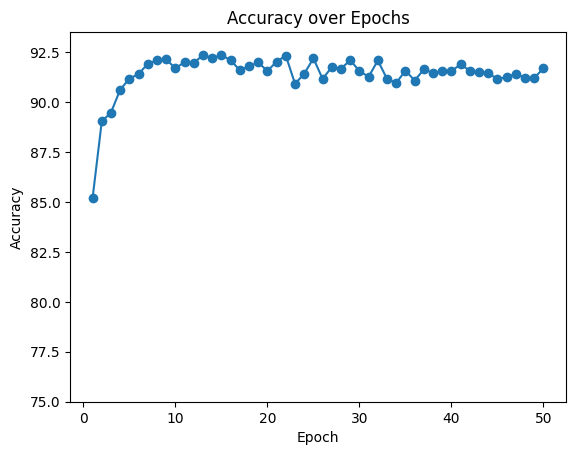

In [9]:
# 绘制准确率的epoch图
plt.plot(range(1, num_epochs+1), accuracy_list, marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylim(75, 93.5)
plt.ylabel('Accuracy')
plt.show()

In [10]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Assuming the target is categorical
# Convert to tensors
X_tensor_test = torch.tensor(X_scaled_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.values, dtype=torch.long)  # Assuming the target is categorical
# Create a dataset
train_dataset = TensorDataset(X_tensor, y_tensor)
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)

criterion = nn.CrossEntropyLoss()

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

# 定义评估指标
scoring = make_scorer(accuracy_score)

# 定义参数空间
param_grid = {
    'hidden_size': [256],
    'dropout1': [0.3],
    'dropout2': [0.5],
    'dropout3': [0.4],
    'learning_rate': [0.001]
}
def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return f1, recall, auc

best_f1, best_recall, best_auc = 0, 0, 0
best_accuracy = 0
accuracy_list = []
accuracy_train_list = []
best_params = {}

for params in ParameterGrid(param_grid):
    model = BiLSTM(input_size=X_train.shape[1], hidden_size=params['hidden_size'], 
                           output_size=2, sequence_length=3)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # 训练模型
    num_epochs = 200
    for epoch in tqdm(range(num_epochs), desc='Epoch'):
        total_train = 0
        correct_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()   
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # 梯度裁剪
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=20)  # 设置梯度的最大范数为20
            optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)  # 累加总样本数
        correct_train += (predicted == labels).sum().item()
        accuracy_train = 100 * correct_train / total_train 
        accuracy_train_list.append(accuracy_train)  # 记录准确率
        # 评估模型
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.unsqueeze(1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)  # 累加总样本数
                
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())
        accuracy = 100 * correct / total 
        accuracy_list.append(accuracy)  # 记录准确率
        f1, recall, auc = calculate_metrics(y_true, y_pred)
print(f'F1_score: {f1:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 200/200 [54:55<00:00, 16.48s/it]


F1_score: 0.9296, Recall: 0.9390, AUC: 0.9251


In [11]:
print(f'accuracy: {accuracy:.2f}%')

accuracy: 92.57%
